### 8 비지도 학습
#### 8.1 K-평균 알고리즘

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

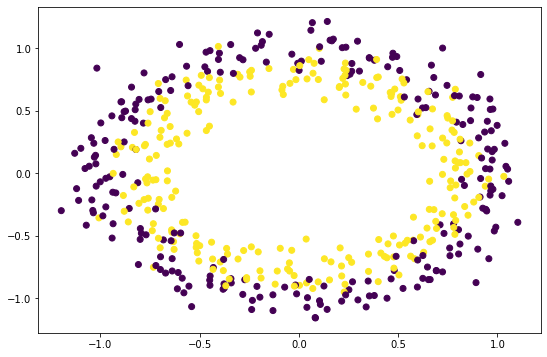

In [11]:
# Make a large circle containing a smaller circle in 2d. 
# A simple toy dataset to visualize clustering and classification algorithms.
# X: ndarray of shape (n_samples, 2)
# The generated samples.
# y: ndarray of shape (n_samples,)
# The integer labels (0 or 1) for class membership of each sample.
X, y = make_circles(n_samples=500, noise=0.1)
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


In [21]:
# numpy sum(), axis(축) 이해
arr = np.random.rand(3,2)
print(arr)
sum_axis0 = np.sum(arr, axis=0) # 배열의 첫번째 차원을 더해서 1개로 만듬 => (*3, 2) => (2,)
sum_axis1 = np.sum(arr, axis=1) # 배열의 두번째 차원을 더해서 1개로 만듬 => ( 3,*2) => (3,)
print(sum_axis0)
print(sum_axis1)

[[0.33071315 0.80033735]
 [0.46292327 0.57655938]
 [0.12434089 0.55639448]]
[0.91797731 1.93329121]
[1.1310505  1.03948265 0.68073536]


In [ ]:
# 텐서 데이터 변환화기
X = torch.FloatTensor(X)

# K-평균 알고리즘
def L2distance(a,b):
    return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0)